## Task

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

# I Libraries and Functions

## 1 Import libraries

In [4]:
from google.colab import drive, files
import os
import shutil
import time
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve

## 2 Definition of functions

In [20]:
star = lambda x:"\n" + x*50 + "\n"

def Mkdir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0))
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0))
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0))
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0))
    metrics_dict = {"f1": f1, "roc": roc, "rec": rec, "prc": prc}
    return metrics_dict

# II Preporation Data

## 3 Load dataset

In [6]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [7]:
path_to_work_dir = "/content/drive/MyDrive/HW6_MOB/"

In [8]:
# Mkdir(path_to_work_dir)

In [9]:
# new_file = files.upload()

In [10]:
# shutil.move("/content/archive.zip", path_to_work_dir)

In [11]:
# os.listdir(path_to_work_dir)

In [12]:
# !unzip "/content/drive/MyDrive/HW6_MOB/archive.zip" -d "/content/drive/MyDrive/HW6_MOB/"

In [13]:
os.listdir(path_to_work_dir)

['diabetes_binary_health_indicators_BRFSS2015.csv',
 'diabetes_binary_5050split_health_indicators_BRFSS2015.csv',
 'diabetes_012_health_indicators_BRFSS2015.csv',
 'archive.zip',
 'Diabetes_dataset_info.txt',
 'df.csv']

## 4 Review dataset

### 4.1 Description of features

In [14]:
with open(path_to_work_dir + "Diabetes_dataset_info.txt", "r", encoding="utf-8") as f:
    for row in f:
        print(row)

ID - Patient ID

Diabetes_binary - 0 = no diabetes 1 = prediabetes or diabetes

HighBP - 0 = no high BP 1 = high BP

HighChol - 0 = no high cholesterol 1 = high cholesterol

CholCheck - 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years

BMI - Body Mass Index

Smoker - Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes

Stroke - (Ever told) you had a stroke. 0 = no 1 = yes

HeartDiseaseorAttack - coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes

PhysActivity - physical activity in past 30 days - not including job 0 = no 1 = yes

Fruits - Consume Fruit 1 or more times per day 0 = no 1 = yes

Veggies - Consume Vegetables 1 or more times per day 0 = no 1 = yes

HvyAlcoholConsump - Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week) 0 = no 1 = yes

AnyHealthcare - Have any kind of health care coverage, including health insura

In [15]:
df = pd.read_csv(path_to_work_dir + "diabetes_binary_5050split_health_indicators_BRFSS2015.csv", sep=",")

In [16]:
df.shape

(70692, 22)

In [17]:
df.head(7)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
5,0.0,0.0,0.0,1.0,18.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,2.0,7.0,0.0,0.0,0.0,1.0,4.0,7.0
6,0.0,0.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,13.0,5.0,6.0


In [18]:
df.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

### 4.2 Review target value

In [21]:
df["Diabetes_binary"].value_counts()

0.0    35346
1.0    35346
Name: Diabetes_binary, dtype: int64

In [22]:
df.isna().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [23]:
target = "Diabetes_binary"

In [24]:
df.drop(["Education", "Income"], axis=1, inplace=True)

In [25]:
df.head(7)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0
5,0.0,0.0,0.0,1.0,18.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,7.0,0.0,0.0,0.0,1.0
6,0.0,0.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,13.0


## 5 Standartization of features

In [26]:
scaler = MinMaxScaler()
values_dict = {}
for col in df.columns[1:]:
    if len(df[col].value_counts().index.to_list()) > 2:
        values_dict[col] = df[col].value_counts().index.to_list()
for col in values_dict.keys():
    arr_col = np.asarray(df[col]).reshape(-1, 1)
    df[col] = scaler.fit_transform(arr_col)

In [27]:
values_dict.keys()

dict_keys(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age'])

## 6 Definition of important features

In [28]:
model = LogisticRegression()

In [29]:
model.fit(df.iloc[:,1:], df[target])
importance = model.coef_

In [30]:
importance[0]

array([ 0.74927823,  0.57909606,  1.32999882,  6.35952614,  0.01598197,
        0.18094618,  0.25947877, -0.05271508, -0.04487562, -0.10079697,
       -0.78300691, -0.02396544,  0.06913152,  2.44971844, -0.10003306,
       -0.2492125 ,  0.16426978,  0.22174613,  1.87695307])

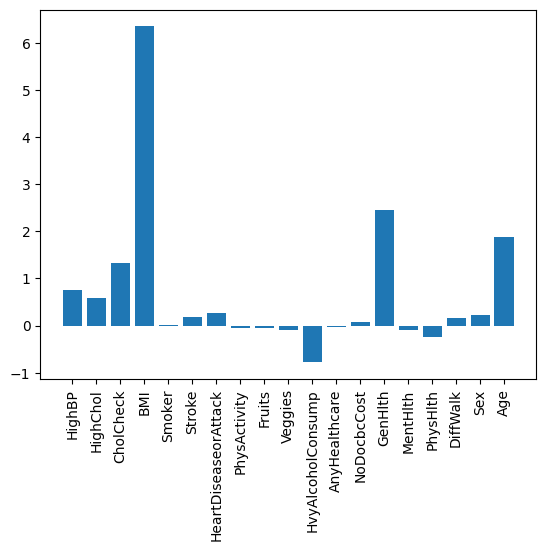

In [31]:
plt.bar([x for x in range(len(importance[0]))], importance[0], tick_label=df.iloc[:,1:].columns)
plt.xticks(rotation=90)
plt.show()

In [32]:
feature_importance = []
for i,v in enumerate(importance[0]):
    if v > 0.25:
        feature_importance.append(df.iloc[:,1:].columns[i])
feature_importance

['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'HeartDiseaseorAttack',
 'GenHlth',
 'Age']

In [33]:
df = df[feature_importance + [target]]

In [34]:
df.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'HeartDiseaseorAttack',
       'GenHlth', 'Age', 'Diabetes_binary'],
      dtype='object')

In [35]:
df.to_csv(path_to_work_dir + "df.csv", index=None)

In [36]:
df = pd.read_csv(path_to_work_dir + "df.csv")

In [37]:
df.head(5)

,HighBP,HighChol,CholCheck,BMI,HeartDiseaseorAttack,GenHlth,Age,Diabetes_binary
0,1.0,0.0,1.0,0.162791,0.0,0.50,0.250000,0.0
1,1.0,1.0,1.0,0.162791,0.0,0.50,0.916667,0.0
2,0.0,0.0,1.0,0.162791,0.0,0.00,1.000000,0.0
3,1.0,1.0,1.0,0.186047,0.0,0.50,0.833333,0.0
4,0.0,0.0,1.0,0.197674,0.0,0.25,0.583333,0.0


## 7 Split data

In [38]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=42)

In [39]:
df_train[target].value_counts()

1.0    30097
0.0    29991
Name: Diabetes_binary, dtype: int64

In [40]:
df_test[target].value_counts()

0.0    5355
1.0    5249
Name: Diabetes_binary, dtype: int64

In [41]:
df_test.drop(target, axis=1, inplace=True)

In [42]:
df_test.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'HeartDiseaseorAttack',
       'GenHlth', 'Age'],
      dtype='object')

In [43]:
x_train, x_test, y_train, y_test = train_test_split(df_train.iloc[:,:-1], df_train[target], test_size=0.3, random_state=42)

# III Learn of models

## 8 Logistic Regression

In [44]:
Lr = LogisticRegression()

In [45]:
Lr.fit(x_train, y_train)

LogisticRegression()

In [49]:
preds_lr = Lr.predict(x_test)

In [50]:
print(classification_report(y_test, preds_lr))

              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74      8922
         1.0       0.74      0.77      0.76      9105

    accuracy                           0.75     18027
   macro avg       0.75      0.75      0.75     18027
weighted avg       0.75      0.75      0.75     18027



In [51]:
metrics_lr = evaluate_results(y_test, preds_lr)

Classification results:
f1: 75.56%
roc: 74.84%
recall: 76.92%
precision: 74.24%


## 9 Random Forest Classifier

In [52]:
Rf = RandomForestClassifier()

In [53]:
Rf.fit(x_train, y_train)

RandomForestClassifier()

In [54]:
preds_rf = Rf.predict(x_test)

In [55]:
print(classification_report(y_test, preds_rf))

              precision    recall  f1-score   support

         0.0       0.73      0.70      0.71      8922
         1.0       0.72      0.75      0.73      9105

    accuracy                           0.72     18027
   macro avg       0.72      0.72      0.72     18027
weighted avg       0.72      0.72      0.72     18027



In [56]:
metrics_rf = evaluate_results(y_test, preds_rf)

Classification results:
f1: 73.26%
roc: 72.36%
recall: 74.90%
precision: 71.69%


## 10 XGBoost

In [57]:
Xg = xgb.XGBClassifier()

In [58]:
Xg.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [59]:
preds_xg = Xg.predict(x_test)

In [ ]:
print(classification_report(y_test, preds_xg))

              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73      8922
         1.0       0.73      0.79      0.76      9105

    accuracy                           0.75     18027
   macro avg       0.75      0.75      0.75     18027
weighted avg       0.75      0.75      0.75     18027



In [60]:
metrics_xg = evaluate_results(y_test, preds_xg)

Classification results:
f1: 76.02%
roc: 74.74%
recall: 79.13%
precision: 73.15%


# Definition best model

In [61]:
preds_list = [preds_lr, preds_rf, preds_xg]

In [62]:
for p in preds_list:
    print(classification_report(y_test, p), "\n\n")

              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74      8922
         1.0       0.74      0.77      0.76      9105

    accuracy                           0.75     18027
   macro avg       0.75      0.75      0.75     18027
weighted avg       0.75      0.75      0.75     18027
 


              precision    recall  f1-score   support

         0.0       0.73      0.70      0.71      8922
         1.0       0.72      0.75      0.73      9105

    accuracy                           0.72     18027
   macro avg       0.72      0.72      0.72     18027
weighted avg       0.72      0.72      0.72     18027
 


              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73      8922
         1.0       0.73      0.79      0.76      9105

    accuracy                           0.75     18027
   macro avg       0.75      0.75      0.75     18027
weighted avg       0.75      0.75      0.75     18027
 




In [63]:
for pr in preds_list:
    evaluate_results(y_test, pr)
    print("\n\n")

Classification results:
f1: 75.56%
roc: 74.84%
recall: 76.92%
precision: 74.24%



Classification results:
f1: 73.26%
roc: 72.36%
recall: 74.90%
precision: 71.69%



Classification results:
f1: 76.02%
roc: 74.74%
recall: 79.13%
precision: 73.15%





In [74]:
df_metrics = pd.DataFrame([metrics_lr, metrics_rf, metrics_xg], index=["LogReg", "RFC", "XGB"])

In [75]:
df_metrics

,f1,roc,rec,prc
LogReg,0.755596,0.748444,0.769248,0.742421
RFC,0.732624,0.723600,0.749039,0.716914
XGB,0.760222,0.747433,0.791323,0.731472
